In [3]:
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

c:\Users\irtizahussain\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
def load_images_from_folder(folder_name: str, label: int):
    images = []
    
    # Only select first 290 images for reducing computation time
    image_files = [f for f in os.listdir(folder_name) if f.endswith(('.jpg', '.jpeg', '.png'))][:290]
    
    for image_file in image_files:
        image_path = os.path.join(folder_name, image_file)
        
        # Read image
        img = cv2.imread(image_path)
        if img is None:
            continue
        
        # Resize image to 64x64
        img_resized = cv2.resize(img, (64, 64))
        
        # Convert image to numpy array and normalize
        img_array = img_resized.astype(np.float32) / 255.0
        
        # Flatten the image array and append to list
        images.append(img_array.flatten())
    
    # Convert list to numpy array
    images_array = np.array(images).T  # Transpose to get shape (number_of_pixels, number_of_images)
    
    # Create labels array
    labels_array = np.full((1, images_array.shape[1]), label)
    
    return images_array, labels_array

In [5]:
cat_images, cat_labels = load_images_from_folder("PetImages/Cat", 1)
dog_images, dog_labels = load_images_from_folder("PetImages/Dog", 0)
# Combine cats and dogs arrays
combined_images_array = np.hstack((cat_images, dog_images))
combined_labels_array = np.hstack((cat_labels, dog_labels))

# Save or use the combined arrays as needed
print(f"Images array shape: {combined_images_array.shape}")
print(f"Labels array shape: {combined_labels_array.shape}")


Images array shape: (12288, 578)
Labels array shape: (1, 578)


In [6]:
def shuffle_and_split_data(
    images_array, labels_array, test_size=0.2, random_state=None
):
    # Generate indices and shuffle them
    num_images = images_array.shape[1]
    indices = np.arange(num_images)
    np.random.shuffle(indices)

    # Apply shuffle to images and labels
    images_array_shuffled = images_array[:, indices]
    labels_array_shuffled = labels_array[:, indices]

    # Split the data into training and testing sets
    train_images, test_images, train_labels, test_labels = train_test_split(
        images_array_shuffled.T,  # Transpose back to (number_of_images, number_of_pixels)
        labels_array_shuffled.T,  # Transpose back to (number_of_images, 1)
        test_size=test_size,
        random_state=random_state,
    )

    # Transpose back to (number_of_pixels, number_of_images) for consistency
    train_images = train_images.T
    test_images = test_images.T
    train_labels = train_labels.T
    test_labels = test_labels.T

    return (train_images, train_labels), (test_images, test_labels)

In [7]:
(x_train, y_train), (x_test, y_test) = shuffle_and_split_data(
    combined_images_array,
    combined_labels_array,
    test_size=0.2,  # 20% of the data for testing
    random_state=42  # For reproducibility
)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((12288, 462), (1, 462), (12288, 116), (1, 116))

In [8]:
def sigmoid(z: np.ndarray) -> np.ndarray:
    return 1 / (1 + np.exp(-z))

In [9]:
def tanh(z: np.ndarray) -> np.ndarray:
    return np.tanh(z)

In [10]:
def initialize_with_zeros(dimensions: tuple) -> tuple[np.ndarray, int]:
    w = np.zeros(dimensions)
    b = 0
    return w, b

In [11]:
def propagate(
    w: np.ndarray, b: int, X: np.ndarray, Y: np.ndarray
) -> tuple:
    m = X.shape[1]  # number of images

    # Number of columns in w.T should be equal to the number of rows in X
    # In this case, if each image is 64*64, then w.T should be (1, 12288) and X should be (12288, number_of_images)
    # A would be (1, number_of_images)

    # Forward propagation

    A = sigmoid(np.dot(w.T, X) + b)

    cost = (-1 / m) * (np.dot(Y, np.log(A + 1e-8).T) + np.dot((1 - Y), np.log(1 - A + 1e-8).T))
    cost = np.squeeze(cost)

    # Backward propagation
    dw = (1 / m) * (np.dot(X, (A - Y).T))
    db = (1 / m) * np.sum((A - Y))

    return dw, db, cost

In [12]:
def optimize(
    w: np.ndarray,
    b: int,
    num_iterations: int,
    learning_rate: float,
    X: np.ndarray,
    Y: np.ndarray,
) -> tuple[np.ndarray, int, list[float]]:
    costs = []
    for i in range(num_iterations):
        dw, db, cost = propagate(w, b, X, Y)
        w = w - learning_rate * dw
        b = b - learning_rate * db

        if i % 100 == 0:
            print("Cost after iteration %i: %f" % (i, cost))

        costs.append(cost)

    return w, b, costs


In [13]:
def model_with_sigmoid_function(num_iterations: int, learning_rate: float, X_train: np.ndarray, X_test: np.ndarray, Y_train: np.ndarray, Y_test: np.ndarray) -> dict:
    w, b = initialize_with_zeros((X_train.shape[0], 1))

    w, b, costs = optimize(w, b, num_iterations, learning_rate, X_train, Y_train)

    y_prediction_train = sigmoid(np.dot(w.T, X_train) + b)
    y_prediction_test = sigmoid(np.dot(w.T, X_test) + b)

    for i in range(y_prediction_train.shape[1]):
        if y_prediction_train[0, i] > 0.5:
            y_prediction_train[0, i] = 1
        else:
            y_prediction_train[0, i] = 0

    for i in range(y_prediction_test.shape[1]):
        if y_prediction_test[0, i] > 0.5:
            y_prediction_test[0, i] = 1
        else:
            y_prediction_test[0, i] = 0
            
            
    print("train accuracy: {} %".format(100 - np.mean(np.abs(y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(y_prediction_test - Y_test)) * 100))

    return {
        "w": w,
        "b": b,
        "costs": costs,
        "y_prediction_train": y_prediction_train,
        "y_prediction_test": y_prediction_test,
        "learning_rate": learning_rate,
    }

In [14]:
def model_with_tanh_function(num_iterations: int, learning_rate: float, X_train: np.ndarray, X_test: np.ndarray, Y_train: np.ndarray, Y_test: np.ndarray) -> dict:
    w, b = initialize_with_zeros((X_train.shape[0], 1))

    w, b, costs = optimize(w, b, num_iterations, learning_rate, X_train, Y_train)

    y_prediction_train = tanh(np.dot(w.T, X_train) + b)
    y_prediction_test = tanh(np.dot(w.T, X_test) + b)

    for i in range(y_prediction_train.shape[1]):
        if y_prediction_train[0, i] > 0:
            y_prediction_train[0, i] = 1
        else:
            y_prediction_train[0, i] = 0

    for i in range(y_prediction_test.shape[1]):
        if y_prediction_test[0, i] > 0.5:
            y_prediction_test[0, i] = 1
        else:
            y_prediction_test[0, i] = 0
            
            
    print("train accuracy: {} %".format(100 - np.mean(np.abs(y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(y_prediction_test - Y_test)) * 100))

    return {
        "w": w,
        "b": b,
        "costs": costs,
        "y_prediction_train": y_prediction_train,
        "y_prediction_test": y_prediction_test,
        "learning_rate": learning_rate,
    }

In [15]:
print("Sigmoid Function")

logistic_regression_model_with_sigmoid_function = model_with_sigmoid_function(
    2500, 0.005, x_train, x_test, y_train, y_test
)
print("Tanh Function")

logistic_regression_model_with_tanh_function = model_with_tanh_function(
    2500, 0.005, x_train, x_test, y_train, y_test
)

Sigmoid Function
Cost after iteration 0: 0.693147
Cost after iteration 100: 1.219096
Cost after iteration 200: 1.081876
Cost after iteration 300: 0.971606
Cost after iteration 400: 0.883406
Cost after iteration 500: 0.810278
Cost after iteration 600: 0.746951
Cost after iteration 700: 0.690288
Cost after iteration 800: 0.638483
Cost after iteration 900: 0.590444
Cost after iteration 1000: 0.545469
Cost after iteration 1100: 0.503072
Cost after iteration 1200: 0.462899
Cost after iteration 1300: 0.424669
Cost after iteration 1400: 0.388171
Cost after iteration 1500: 0.353298
Cost after iteration 1600: 0.320243
Cost after iteration 1700: 0.290332
Cost after iteration 1800: 0.268685
Cost after iteration 1900: 0.258786
Cost after iteration 2000: 0.251910
Cost after iteration 2100: 0.245455
Cost after iteration 2200: 0.239341
Cost after iteration 2300: 0.233530
Cost after iteration 2400: 0.227994
train accuracy: 97.83549783549783 %
test accuracy: 56.03448275862069 %
Tanh Function
Cost after

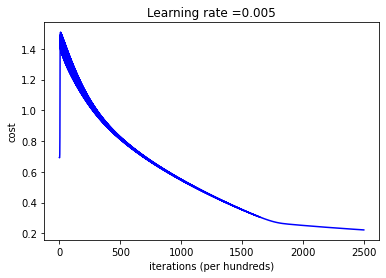

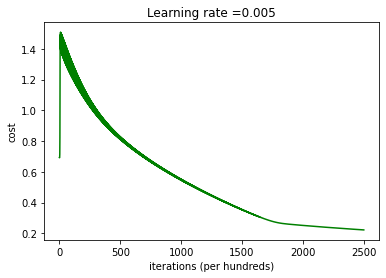

In [16]:
X = np.arange(0, 2500, 1)

plt.plot(
    X,
    logistic_regression_model_with_sigmoid_function["costs"],
    label="Sigmoid function",
    color="blue",
)
plt.ylabel("cost")

plt.xlabel("iterations (per hundreds)")

plt.title(
    "Learning rate ="
    + str(logistic_regression_model_with_sigmoid_function["learning_rate"])
)
plt.show()

plt.plot(
    X,
    logistic_regression_model_with_tanh_function["costs"],
    label="Tanh function",
    color="green",
)
plt.ylabel("cost")
plt.xlabel("iterations (per hundreds)")
plt.title(
    "Learning rate ="
    + str(logistic_regression_model_with_tanh_function["learning_rate"])
)
plt.show()